# SVM

svm(Support Vector Machine)の最適化の目的はマージン（決定境界と境界に最も近いトレーニングサンプルとの間の距離）を最大化すること<br>
マージンを大きくすると汎化誤差が小さくなる<br>
マージンの小さいモデルは過学習に陥りがち<br>

正の超平面
$$
w_0 + {\bf w^Tx_{pos}} = 1
$$

負の超平面
$$
w_0 + {\bf w^Tx_{neg}} = -1
$$

正負の式を引き算すると
$$
{\bf w^T(x_{pos} - x_{neg})} = 2
$$

ここでベクトルの長さを定義する

$$
\|{\bf w}\| = \sqrt{\sum_{j=1}^mw_j^2}
$$

引き算の式と長さから以下の式が得られる

$$
\frac{{\bf w^T(x_{pos} - x_{neg})}}{\|w\|} = \frac{2}{\|w\|}
$$

上記は正負の超平面の距離と解釈できる

※ヘッセの公式<br>
点A($x_0$, $y_0$)から直線ax + by + c = 0に下ろした垂線の長さdは

$$
d = \frac{|ax_0 + by_0 + c|}{\|w\|}
$$

SVMの目的は $\frac{2}{\|w\|}$を最大化すること（実際には逆数をとって２乗した$\frac{1}{2}\|w\|^2$を最小化する）

$$
w_0 + {\bf w^Tx^{(i)}} \ge 1 (y^{(i)} = 1)
$$
$$
w_0 + {\bf w^Tx^{(i)}} \lt -1 (y^{(i)} = -1)
$$

上記の式は負のサンプルは負の超平面の側に、正のサンプルは正の超平面の側にある

# スラック変数を使って、非線形分離不可能なケースに対応（ソフトマージン）

線形制約を緩和するため、スラック変数$\xi$ を導入

$$
{\bf w^Tx^{(i)}} \ge 1 - \xi^{(i)} (y^{(i)} = 1)
$$
$$
{\bf w^Tx^{(i)}} \lt -1 + \xi^{(i)} (y^{(i)} = -1)
$$

※$\xi$は各サンプルごとにある

スラック変数を導入した場合の最小化する対象は

$$
\frac{1}{2}\|{\bf w}\| + C\left[\sum_i\xi^{(i)}\right]
$$

※$\xi$は誤分類の程度を表すため、最小化の対象にする

Cが大きい場合は誤分類のペナルティが大きいことを示し（高バリアンス）、小さい場合は誤分類に寛大（高バイアス）

In [1]:
from sklearn import datasets
import numpy as np

# iris データセットをロード
iris = datasets.load_iris()
# 3,4列目の特徴量を抽出
X = iris.data[:, [2, 3]]
# クラスラベルを取得
y = iris.target

from sklearn.model_selection import train_test_split
# 全体の30% をテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# トレーニングデータの平均と標準偏差を計算
sc.fit(X_train)
# 計算した結果を元にデータを標準化
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# トレーニングデータとテストデータを行方向に結合
X_combined_std = np.vstack((X_train_std, X_test_std))
# 同様にクラスラベルも結合
y_combined = np.hstack((y_train, y_test))

In [2]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02, xlabel='x', ylabel='y', title='title', legend_loc='upper left'):
    
    # マーカーとカラーマップの準備
    markers = ('s', 'o', 'v', '^', 'x')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # グリッドポイントの生成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    #print 'xx1'
    #print xx1
    #print 'xx2'
    #print xx2
    #print 'xx1.ravel()'
    #print xx1.ravel()
    #print 'xx2.ravel()'
    #print xx2.ravel()
    
    # 各特徴量を1次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    #print 'Z'
    #print Z
    # グリッドポイントの等高線のプロット
    plt.contourf(xx1, xx2, Z, aplha=0.4, cmap=cmap)
    # 軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # クラスごとにサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)
        
    # テストサンプルを目立たせる
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='',
                   alpha=1.0, linewidths=1, marker='o',
                   s=55, label='test set')
        
    # 軸のラベルの設定
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # タイトル設定
    plt.title(title)
    # 凡例の設定
    plt.legend(loc=legend_loc)
    # 図の表示
    plt.show()

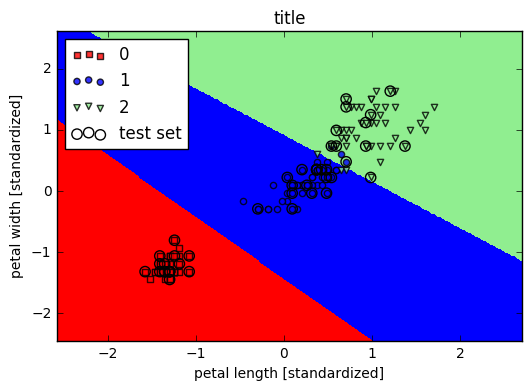

In [3]:
from sklearn.svm import SVC
# 線形SVMのインスタンスを生成
svm = SVC(kernel='linear', C=1.0, random_state=0)
# 線形SVMのモデルにトレーニングデータをfitさせる
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105,150),
                      xlabel='petal length [standardized]', ylabel='petal width [standardized]')

メモ：線形ロジスティック回帰と線形SVMの結果は似たものになることが多いが、ロジスティック回帰はトレーニングデータセットの条件付き尤度を最大化するアルゴリズムのため、より外れ値の影響を受けやすい。が、SVMより実装しやすく、単純なモデルであり、簡単に更新できる。

# カーネルSVMを使って非線形問題を解く

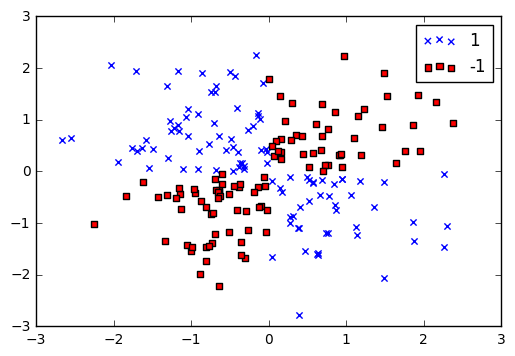

In [4]:
# XORゲート形式のデータセットを作成する
# 乱数種を設定
np.random.seed(0)
# 標準正規分布に従う乱数で、200行（200サンプル）　2列（2特徴量）のデータを作成
X_xor = np.random.randn(200, 2)
# どちらかが正でどちらかが、負のときのみtrue
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
# trueのとき1, falseのとき-1
y_xor = np.where(y_xor, 1, -1)
# 1を青でプロット
plt.scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1], c='b', marker='x', label='1')
# -1を赤でプロット
plt.scatter(X_xor[y_xor==-1, 0], X_xor[y_xor==-1, 1], c='r', marker='s', label='-1')
# 軸の範囲を指定
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.show()

XORのように線形分離できない場合、ロジスティック回帰やSVMではうまく分割できない<br>
そういったデータを処理するのがカーネル手法で射影関数$\phi(\cdot)$を使ってそれらの組み合わせを高次元空間に射影し、<br>
線形分離できるようにする手法である<br>
射影関数
$$
\phi(x_1, x_2) = (z_1, z_2, z_3) = (x_1, x_2, x_1^2 + x_2^2)
$$

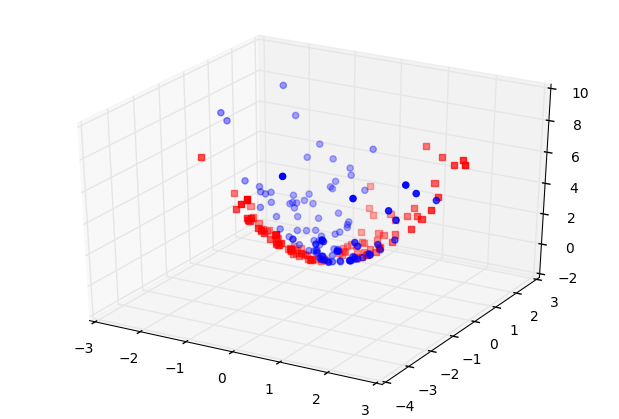

In [5]:
#射影してみた

from mpl_toolkits.mplot3d.axes3d import Axes3D
z = X_xor[:, 0]**2 + X_xor[:, 1]**2

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1], X_xor[y_xor==1, 0]**2 + X_xor[y_xor==1, 1]**2, color="b", marker="o")
ax.scatter(X_xor[y_xor==-1, 0], X_xor[y_xor==-1, 1], X_xor[y_xor==-1, 0]**2 + X_xor[y_xor==-1, 1]**2, color="r", marker="s")

plt.show()

カーネル関数について<br>
新しい特徴量を作るコストが高い（特に高次元データの場合）<br>
しかし、SVMの場合、ベクトルの内積が分かれば答えは出せる<br>
射影したあとの特徴空間の内積は、元の特徴ベクトルの関数になっているはず。<br>
それ（射影した特徴空間の内積）を
$$
k(x^{(i)}, x^{(j)}) = \phi(x^{(i)})\cdot\phi(x^{(j)})
$$
とあらわす。これをカーネル関数という。<br>
カーネル関数さえ求まれば,$\phi$（射影）は求める必要がないので、「カーネルトリック」という<br>

有名なカーネルには<br>
多項式カーネル
$$
k(x^{(i)}, x^{(j)}) = (x^{(i)} \cdot x^{(j)} + 1)^d
$$
ガウシアンカーネル（RBFカーネル）
$$
k(x^{(i)}, x^{(j)}) = exp(-\gamma\|x^{(i)} - x^{(j)}\|^2)
$$
ここで
$
\gamma = \frac{1}{2\sigma^2}
$
は最適化されるパラメータ<br>
カーネルという用語は２つのサンプル間の類似性を表す関数と解釈できる。(距離にマイナスをかけて類似度にしている)<br>
指数関数のべき乗部分が0からマイナス無限大なので、類似度は1（全く同じ）から0（全く違う）の範囲になる

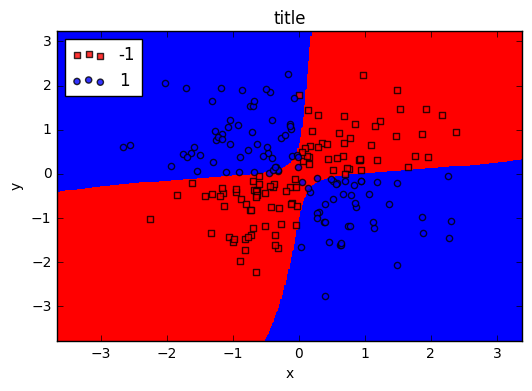

In [6]:
# RBFカーネルによるsvmのインスタンスを生成
svm = SVC(kernel='rbf', random_state=0, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)

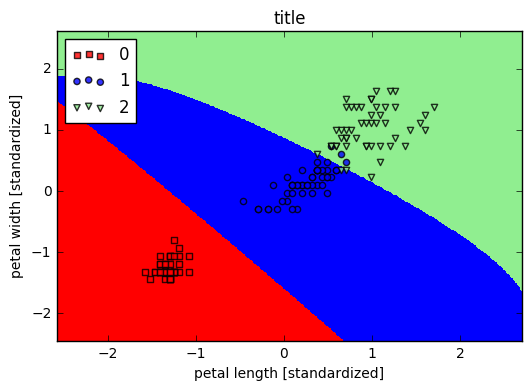

In [7]:
# irisデータでsvm
svm = SVC(kernel='rbf', random_state=0, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm, xlabel='petal length [standardized]', ylabel='petal width [standardized]')

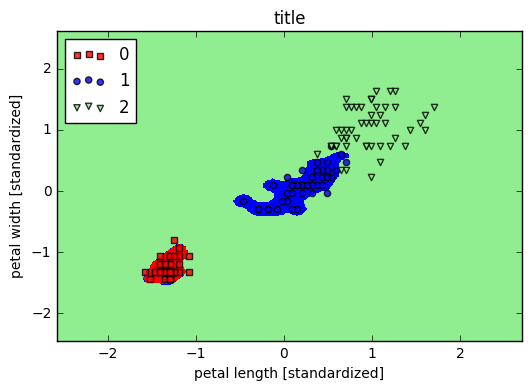

In [8]:
# γパラメータの値を大きくしてみる →　過学習気味になる
svm = SVC(kernel='rbf', random_state=0, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm, xlabel='petal length [standardized]', ylabel='petal width [standardized]')